In [462]:
import torch
import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from models.depth_model import StereoDepthNet as DepthNetwork
from datasets.robotcar.depth_test_dataloder import RobotcarTest

In [2]:

import argparse
args = argparse.ArgumentParser()
args.image_height = 192
args.image_width = 320
args.working_resolution = (args.image_width, args.image_height)
args.use_gt_poses = False
args.use_gray_scale = False
args.use_stereo = True
args.batch_size = 1
args.use_pair = True
args.split = "train"
args.test_file_path = '/home/madhu/code/feature-slam/git_repos/2014-12-16-18-44-24_paried_day_test.txt'
args.data_path = '/mnt/nas/madhu/data/robotcar/2014-12-16-18-44-24/test_split'
args.pair_data_path = '/mnt/nas/madhu/data/robotcar/2014-12-09-13-21-02/test_split'
dataset = RobotcarTest(args)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=args.batch_size, shuffle=True
)


DAY NIGHT TEST DATASET


In [3]:
def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

In [4]:
depth_net = DepthNetwork(args, reg_refine=False)
depth_net.cuda()
depth_net.model.eval()
checkpoint_path = '/mnt/nas/madhu/data/checkpoints/chapter_4_cvpr/d_n_same_transfer_fusion_fp_16_v2/depth_net_15.pth'
#checkpoint_path = '/mnt/nas/madhu/data/checkpoints/chapter_4_cvpr/icra_2024_reproduce/depth_net_15.pth'
checkpoint = torch.load(checkpoint_path)
depth_net.load_state_dict(checkpoint,strict=True)

Using cache found in /home/madhu/.cache/torch/hub/facebookresearch_dino_main


<All keys matched successfully>

In [463]:
for idx,data in enumerate(dataloader):break

In [6]:
gt_depth = np.load('sample_depths_0_10_night.npy')
#np.save('sample_depths_0_10_night.npy',gt_depth[0:10])

In [7]:
from git_repos.day_night_diffusion.uncond_image_generation.denoise_image import get_model,denoise

diffusion_model, noise_scheduler = get_model()
print('Loaded the diffusion model and the noise_schedular')    


Loaded the diffusion model and the noise_schedular


In [8]:
def denoise(img, model, noise_scheduler):
    # This is image2image diffusion process
    print('Denoising the image')
    with torch.no_grad():
        num_inference_steps = 100
        strength = 0.1
        offset = 0
        noise_scheduler.set_timesteps(num_inference_steps)
        init_timestep = int(num_inference_steps * strength)
        init_timestep = min(init_timestep, num_inference_steps)


        #timesteps = noise_scheduler.timesteps[-init_timestep]
        #timesteps = torch.tensor([timesteps] * 1, dtype=torch.long, device=model.device)
        gamma_img = img ** 0.35
        norm_img =  gamma_img * 2 - 1
        #random_seed =  torch.randint(0, 1000000, (1,)).item()
        #generator = torch.Generator(device='cpu').manual_seed(random_seed)
        #noise = torch.randn(img.shape, generator=generator).cuda()
        #init_latents = noise_scheduler.add_noise(norm_img, noise, timesteps).to(img.device)
        latents = norm_img
        t_start = max(num_inference_steps - init_timestep, 0)
        #print(noise_scheduler.timesteps[t_start:])
        for i, t in enumerate(noise_scheduler.timesteps[t_start:]):
            #t_index = t_start + i
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                noise_pred = model(latents, t).sample
            latents = noise_scheduler.step(noise_pred, t, latents).prev_sample


        latents = (latents / 2 + 0.5).clamp(0, 1)
        #denoised_image = latents.cpu().permute(0, 2, 3, 1).numpy()
       

    return latents

In [464]:
night_left_image = data['frame0']['image'].cuda()
night_right_image = data['frame0']['stereo_pair'].cuda()

day_left_image = data['frame0']['pair_image'].cuda()
day_right_image = data['frame0']['pair_stereo_pair'].cuda()


night_left_image = torch.nn.functional.interpolate(night_left_image, (192, 320), mode='bilinear', align_corners=True)
night_right_image = torch.nn.functional.interpolate(night_right_image, (192, 320), mode='bilinear', align_corners=True)

#night_left_image = denoise(night_left_image, diffusion_model, noise_scheduler)
#night_right_image = denoise(night_right_image, diffusion_model, noise_scheduler)

#night_left_image = night_left_image ** 0.45
#night_right_image = night_right_image ** 0.45

day_left_image = torch.nn.functional.interpolate(day_left_image, (192, 320), mode='bilinear', align_corners=True)
day_right_image = torch.nn.functional.interpolate(day_right_image, (192, 320), mode='bilinear', align_corners=True)

left_image = torch.cat([night_left_image,day_left_image],dim=0)
right_image = torch.cat([night_right_image,day_right_image],dim=0)


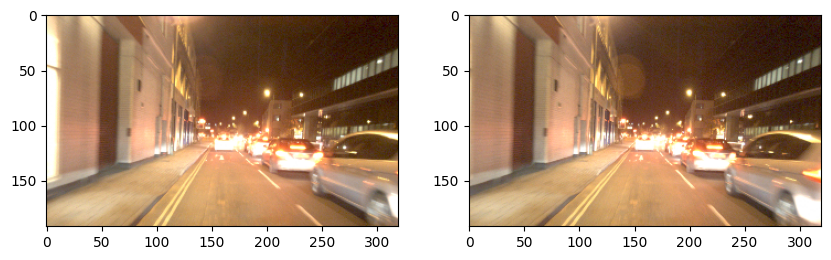

In [465]:
d_l_img = night_left_image.squeeze().cpu().numpy().transpose(1,2,0)
d_r_img = night_right_image.squeeze().cpu().numpy().transpose(1,2,0)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(d_l_img)
plt.subplot(122)
plt.imshow(d_r_img)


In [467]:
with torch.no_grad():
    ouptuts= depth_net(left_image, right_image,return_dict = True)
    features = ouptuts['features'][0]
    night_features, day_features = features[0:1], features[1:2]
    pred_disparity = ouptuts['flow_preds'][0]

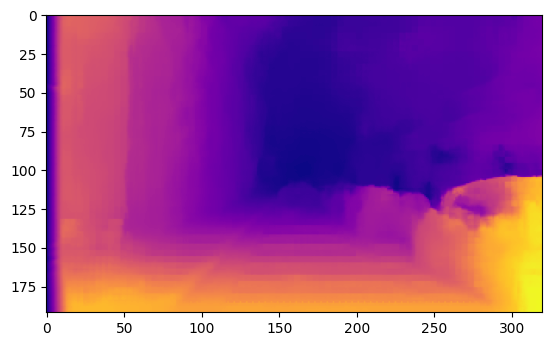

In [468]:
plt.imshow(pred_disparity[0].cpu().numpy(),cmap='plasma')

In [266]:
import cv2
MIN_DEPTH = 1e-3
MAX_DEPTH = 50
ROBOTCAR_SCALE_FACTOR = 0.239983*100.*0.2399
#ROBOTCAR_SCALE_FACTOR = 0.2399 * 983.044006 #* 0.25
#disp = pred_disps[test_index]
depth = gt_depth[1]
disp = pred_disparity[0].detach().cpu().numpy()
print(depth.shape, disp.shape)
disp = cv2.resize(disp, (depth.shape[1], depth.shape[0]))
pred_depth = ROBOTCAR_SCALE_FACTOR  /(disp + 1e-6)

mask = np.logical_and(depth > MIN_DEPTH, depth < MAX_DEPTH)
masked_gt = depth[mask]
masked_pred = pred_depth[mask]
# ratio = np.median(masked_gt / masked_pred)
# masked_pred *= ratio

masked_pred[masked_pred < MIN_DEPTH] = MIN_DEPTH
masked_pred[masked_pred > MAX_DEPTH] = MAX_DEPTH

print("-> Evaluating")
errors = compute_errors(masked_gt, masked_pred)
print("   ", errors)
print("-> Done!")
# with 0.45
#    (0.10976954183968227, 0.9813778787044033, 5.1135769599081184, 0.19723355689913444, 0.8863088265692827, 0.9672362709295115, 0.9825156756011851)
#normal    
#(0.12649709000843562, 1.2066329923050991, 5.832419414335287, 0.2144921600582892, 0.8565251843175085, 0.9597946668504099, 0.9803968855508854)
#ddim 

(768, 1280) (192, 320)
-> Evaluating
    (0.8777143004889388, 16.664082286783206, 21.82564237015781, 2.207330900827767, 0.00032107611193727184, 0.0007604434230093281, 0.0011153170204136812)
-> Done!


In [469]:
flat_night_feat = torch.flatten(night_features, 2)
flat_day_feat = torch.flatten(day_features, 2)
normlized_night_feat = torch.nn.functional.normalize(flat_night_feat, dim=1)
normlized_day_feat = torch.nn.functional.normalize(flat_day_feat, dim=1)
similarity = torch.matmul(normlized_night_feat.transpose(1,2),normlized_day_feat)
# correlation = torch.matmul(flat_night_feat.transpose(1,2), flat_day_feat) / (night_features.shape[1] ** 0.5)  # [B, H, W, W]
# similarity = torch.nn.functional.softmax(correlation, dim=-1)
topk = torch.topk(similarity, k=10, dim=2)


In [470]:
topk

torch.return_types.topk(
values=tensor([[[0.9394, 0.9328, 0.9319,  ..., 0.9295, 0.9287, 0.9283],
         [0.9106, 0.9078, 0.9066,  ..., 0.8988, 0.8987, 0.8982],
         [0.9143, 0.9039, 0.9000,  ..., 0.8804, 0.8802, 0.8795],
         ...,
         [0.9383, 0.9360, 0.9333,  ..., 0.9263, 0.9259, 0.9246],
         [0.9371, 0.9350, 0.9317,  ..., 0.9192, 0.9173, 0.9162],
         [0.9260, 0.9225, 0.9182,  ..., 0.9067, 0.9032, 0.9009]]],
       device='cuda:0'),
indices=tensor([[[  0, 320, 400,  ..., 240, 480, 280],
         [ 81,  41,   1,  ..., 401, 321, 641],
         [  2,  82,  42,  ..., 602,  83,  43],
         ...,
         [959, 958, 957,  ..., 916, 918, 917],
         [959, 958, 957,  ..., 953, 918, 916],
         [959, 958, 957,  ..., 953, 918, 952]]], device='cuda:0'))

In [269]:
from playground.SyncMatch.syncmatch.utils.util import get_grid

def get_keypoints(feat):
    shape = feat.shape
    grid = get_grid(shape[2],shape[3])
    grid = grid.to(feat)
    grid = grid.unsqueeze(0).repeat(shape[0],1,1,1)
    flat_grid = grid.flatten(2)
    return flat_grid[:,:2,:].permute(0,2,1)

def nn_gather(points, indices):
    # expand indices to same dimensions as points
    indices = indices[:, :, None]
    indices = indices.expand(-1, -1, points.shape[2])
    return points.gather(1, indices)

In [471]:
kpts0 = get_keypoints(night_features)
kpts1 = get_keypoints(day_features)
sample_kpts1 = kpts1.repeat(10,1,1)
sample_kpts0 = kpts0.repeat(10,1,1)
inds = topk.indices.permute(2,1,0).squeeze()
corr_kpts1 = nn_gather(sample_kpts1,inds)

In [472]:
values = topk.values.permute(2,1,0).squeeze()

In [272]:
# based on: https://github.com/magicleap/SuperGluePretrainedNetwork/blob/master/models/utils.py
import cv2
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
def plot_matches(image0, image1, kpts0, kpts1, scores=None, layout="lr"):
    """
    plot matches between two images. If score is nor None, then red: bad match, green: good match
    :param image0: reference image
    :param image1: current image
    :param kpts0: keypoints in reference image
    :param kpts1: keypoints in current image
    :param scores: matching score for each keypoint pair, range [0~1], 0: worst match, 1: best match
    :param layout: 'lr': left right; 'ud': up down
    :return:
    """
    H0, W0 = image0.shape[0], image0.shape[1]
    H1, W1 = image1.shape[0], image1.shape[1]

    if layout == "lr":
        H, W = max(H0, H1), W0 + W1
        out = 255 * np.ones((H, W, 3), np.uint8)
        out[:H0, :W0, :] = image0
        out[:H1, W0:, :] = image1
    elif layout == "ud":
        H, W = H0 + H1, max(W0, W1)
        out = 255 * np.ones((H, W, 3), np.uint8)
        out[:H0, :W0, :] = image0
        out[H0:, :W1, :] = image1
    else:
        raise ValueError("The layout must be 'lr' or 'ud'!")

    kpts0, kpts1 = np.round(kpts0).astype(int), np.round(kpts1).astype(int)

    # get color
    if scores is not None:
        smin, smax = scores.min(), scores.max()
        assert (0 <= smin <= 1 and 0 <= smax <= 1)

        color = cm.gist_rainbow(scores)
        color = (np.array(color[:, :3]) * 255).astype(int)[:, ::-1]
    else:
        color = np.zeros((kpts0.shape[0], 3), dtype=int)
        color[:, 1] = 255

    for (x0, y0), (x1, y1), c in zip(kpts0, kpts1, color):
        c = c.tolist()
        if layout == "lr":
            cv2.line(out, (x0, y0), (x1 + W0, y1), color=c, thickness=1, lineType=cv2.LINE_AA)
            # display line end-points as circles
            cv2.circle(out, (x0, y0), 2, c, -1, lineType=cv2.LINE_AA)
            cv2.circle(out, (x1 + W0, y1), 2, c, -1, lineType=cv2.LINE_AA)
        elif layout == "ud":
            cv2.line(out, (x0, y0), (x1, y1 + H0), color=c, thickness=1, lineType=cv2.LINE_AA)
            # display line end-points as circles
            cv2.circle(out, (x0, y0), 2, c, -1, lineType=cv2.LINE_AA)
            cv2.circle(out, (x1, y1 + H0), 2, c, -1, lineType=cv2.LINE_AA)

    return out

tensor([1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000, 0.2000,
        0.1000])


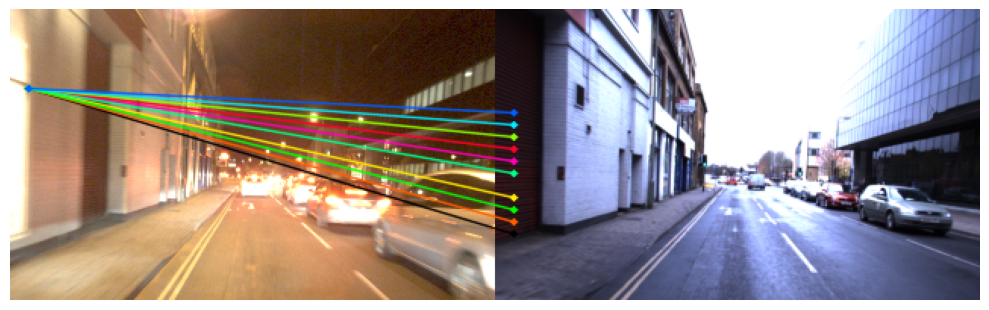

In [483]:
rand_ind = torch.randint(0,kpts0.shape[1],(1,)).item()
query_kpts0 = sample_kpts0[:,rand_ind,:] * 8.0
query_kpts1 = corr_kpts1[:,rand_ind,:] * 8.0
colors = torch.arange(1,11).float() / 10
colors = 1.1 - colors 

# query_kpts0 = query_kpts0[:2]
# query_kpts1 = query_kpts1[:2]
# colors = colors[:2]

#colors = values[:,rand_ind].cpu().numpy()

print(colors)


np_night_image = night_left_image.squeeze().cpu().numpy().transpose(1,2,0)
np_day_image = day_left_image.squeeze().cpu().numpy().transpose(1,2,0)

np_night_image = (np_night_image * 255).astype(np.uint8)
np_day_image = (np_day_image * 255).astype(np.uint8)

np_night_image = cv2.resize(np_night_image, (320, 192))
np_day_image = cv2.resize(np_day_image, (320, 192))

match_img = plot_matches(np_night_image, np_day_image, query_kpts0.squeeze().cpu().numpy(), query_kpts1.squeeze().cpu().numpy(),scores=colors, layout="lr")
plt.figure(figsize=(10,5))
plt.imshow(match_img)
plt.axis('off')
plt.tight_layout()


In [377]:
colors = torch.arange(1,11).float() / 10
print(1.1-colors)

tensor([1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000, 0.2000,
        0.1000])
